In [91]:
# I'm adding a version of this code that was used to draft a version of the manuscript. It includes some 
# un-used analyses (like a pretty effect size matrix / heatmap) and probably a lot of attempts to do things.
# If it hasn't been cleaned up before publication, it should be .... 
# Anything good in here was probably written by chatGPT, and anything bad was probably written by me
# npetersen@ucla.edu 08/06/2024

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/u/home/n/npeterse/helvetica.ttf'
file_path = '/u/home/n/npeterse/TMS_data_copy.csv'
data = pd.read_csv(file_path)

# uncomment the line below to display the first few rows of the dataframe
# data.head()

In [87]:
# main analysis (time-by-site interaction) goes here

# load in csv version of datasheet
file_path = '/u/home/n/npeterse/TMS_data_copy.csv' 
data = pd.read_csv(file_path)

# list of main dependent variables
dvs = ['SJW_SUM_OVERALL', 'PANAS_NEG_TOT', 'UTS_TOT']

# Fit linear mixed models for interaction between time (Pre/Post) and target for each dependent variable
experimental_targets = ['PPC', 'SFG', 'DLPFC']
control_target = 'v5'
results = []

# Function to compute Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

# Models for each dependent variable and each experimental target
for dependent_variable in dvs:
    for target in experimental_targets:
        subset_data = data[data['STITARGET'].isin([target, control_target])]
        # Drop missing values for the relevant dependent variable
        subset_data = subset_data.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])
        if not subset_data.empty:
            # Add a new column to indicate whether the target is experimental or control
            subset_data['TargetGroup'] = subset_data['STITARGET'].apply(lambda x: 'Experimental' if x == target else 'Control')
            model = smf.mixedlm(f"{dependent_variable} ~ PrePost * TargetGroup", subset_data, groups=subset_data["PTID"]).fit()
            interaction_term = 'PrePost[T.Pre]:TargetGroup[T.Experimental]'
            if interaction_term in model.pvalues:
                pre_data = subset_data[(subset_data['PrePost'] == 'Pre') & (subset_data['TargetGroup'] == 'Experimental')][dependent_variable]
                post_data = subset_data[(subset_data['PrePost'] == 'Post') & (subset_data['TargetGroup'] == 'Experimental')][dependent_variable]
                d = cohen_d(pre_data, post_data)
                result = {
                    'Dependent Variable': dependent_variable,
                    'Target': target,
                    'Estimate': model.params[interaction_term],
                    'Standard Error': model.bse[interaction_term],
                    't-value': model.tvalues[interaction_term],
                    'p-value': model.pvalues[interaction_term],
                    'Effect Size (Cohen\'s d)': d,
                    'Random Effects': model.random_effects
                }
                results.append(result)
            else:
                result = {
                    'Dependent Variable': dependent_variable,
                    'Target': target,
                    'Estimate': None,
                    'Standard Error': None,
                    't-value': None,
                    'p-value': None,
                    'Effect Size (Cohen\'s d)': None,
                    'Random Effects': model.random_effects
                }
                results.append(result)

# Convert results to DataFrame for better visualization and reporting
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)

# Optionally, display the DataFrame in Jupyter Notebook for better visualization
import IPython.display as display
display.display(results_df)


  Dependent Variable Target  Estimate  Standard Error  t-value  p-value  \
0    SJW_SUM_OVERALL    PPC    1.4730          1.9197   0.7673   0.4429   
1    SJW_SUM_OVERALL    SFG    4.5144          1.8326   2.4633   0.0138   
2    SJW_SUM_OVERALL  DLPFC    3.4161          1.8632   1.8335   0.0667   
3      PANAS_NEG_TOT    PPC   -0.2524          0.9485  -0.2661   0.7902   
4      PANAS_NEG_TOT    SFG    0.6511          1.1722   0.5555   0.5786   
5      PANAS_NEG_TOT  DLPFC    0.5643          0.9950   0.5671   0.5706   
6            UTS_TOT    PPC    0.9769          2.2378   0.4365   0.6624   
7            UTS_TOT    SFG    4.0018          2.0175   1.9835   0.0473   
8            UTS_TOT  DLPFC    3.5579          2.2419   1.5870   0.1125   

   Effect Size (Cohen's d)                                     Random Effects  
0                   0.0926  {37001: [-11.807964519684697], 37003: [-9.7578...  
1                   0.3286  {37001: [-12.937425612270122], 37003: [-8.6134...  
2        

,Dependent Variable,Target,Estimate,Standard Error,t-value,p-value,Effect Size (Cohen's d),Random Effects
0,SJW_SUM_OVERALL,PPC,1.4730,1.9197,0.7673,0.4429,0.0926,"{37001: [-11.807964519684697], 37003: [-9.7578..."
1,SJW_SUM_OVERALL,SFG,4.5144,1.8326,2.4633,0.0138,0.3286,"{37001: [-12.937425612270122], 37003: [-8.6134..."
2,SJW_SUM_OVERALL,DLPFC,3.4161,1.8632,1.8335,0.0667,0.2780,"{37001: [-11.99604363351965], 37003: [-8.08018..."
3,PANAS_NEG_TOT,PPC,-0.2524,0.9485,-0.2661,0.7902,0.1471,"{37001: [-3.250396328048717], 37003: [-3.14586..."
4,PANAS_NEG_TOT,SFG,0.6511,1.1722,0.5555,0.5786,0.2373,"{37001: [-3.166293920059809], 37003: [-3.16629..."
5,PANAS_NEG_TOT,DLPFC,0.5643,0.9950,0.5671,0.5706,0.2748,"{37001: [-3.7294681739841464], 37003: [-2.3965..."
6,UTS_TOT,PPC,0.9769,2.2378,0.4365,0.6624,0.0976,"{37001: [-12.461312687473109], 37003: [-2.6520..."
7,UTS_TOT,SFG,4.0018,2.0175,1.9835,0.0473,0.2649,"{37001: [-12.367014900354324], 37003: [-0.8007..."
8,UTS_TOT,DLPFC,3.5579,2.2419,1.5870,0.1125,0.2803,"{37001: [-15.116268150836728], 37003: [0.05712..."


In [8]:
# attempting to clean up the for loops from above without breaking anything... looks good, this will be main loop 
# for post hoc t-tests

# added this to try to get more precise p-values but it didn't work (or did it?)
pd.set_option('display.float_format', lambda x: f'{x:.4g}' if abs(x) < 1e-4 else f'{x:.4f}')

# load in csv version
file_path = '/u/home/n/npeterse/TMS_data_copy.csv' 
data = pd.read_csv(file_path)

# commenting this out to attempt to move dropna inside the main loop
#required_columns = ['PANAS_POS_TOT', 'SJW_SUM_OVERALL', 'STITARGET', 'PrePost', 'PTID', 'SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_A', 'SJW_SUM_OVERALL']
#data_clean = data.dropna(subset=required_columns)

# list of all dependent variables
dvs = ['SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_A', 'SJW_SUM_OVERALL', 'PANAS_POS_TOT', 'PANAS_NEG_TOT', 'UTS_TOT']

# Function to compute Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

# Fit linear mixed models for each target separately for PANAS_POS_TOT and SJW subscales
targets = ['PPC', 'SFG', 'v5', 'DLPFC']
results = {}

# Models for each SJW subscale
for dependent_variable in dvs:
    for target in targets:
        subset_data = data_clean[data_clean['STITARGET'] == target]
        # Drop missing values for the relevant dependent variable
        subset_data = subset_data.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])
        if not subset_data.empty:
            model = smf.mixedlm(f"{dependent_variable} ~ PrePost", subset_data, groups=subset_data["PTID"]).fit()
            if 'PrePost[T.Pre]' in model.pvalues:
                pre_data = subset_data[subset_data['PrePost'] == 'Pre'][dependent_variable]
                post_data = subset_data[subset_data['PrePost'] == 'Post'][dependent_variable]
                d = cohen_d(pre_data, post_data)
                results[f'{dependent_variable}_{target}'] = {
                    'p-value': model.pvalues['PrePost[T.Pre]'],
                    'effect_size (Cohen\'s d)': d
                }
            else:
                results[f'{subscale}_{target}'] = {
                    'p-value': None,
                    'effect_size (Cohen\'s d)': None
                }

# Create DataFrame for p-values and effect sizes
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the DataFrame
print(results_df)

# Optionally, display the DataFrame in Jupyter Notebook for better visualization
results_df

                        p-value  effect_size (Cohen's d)
SJW_SUM_C_PPC            0.1051                   0.1341
SJW_SUM_C_SFG         4.119e-05                   0.3600
SJW_SUM_C_v5             0.1051                   0.1398
SJW_SUM_C_DLPFC          0.0002                   0.3919
SJW_SUM_PSY_PPC          0.0804                   0.1990
SJW_SUM_PSY_SFG          0.0246                   0.3135
SJW_SUM_PSY_v5           0.9614                  -0.0130
SJW_SUM_PSY_DLPFC        0.0479                   0.1774
SJW_SUM_PHY_PPC          0.8050                  -0.0425
SJW_SUM_PHY_SFG          0.5644                   0.0664
SJW_SUM_PHY_v5           0.2043                  -0.1171
SJW_SUM_PHY_DLPFC        0.2733                   0.1084
SJW_SUM_SS_PPC           0.3876                   0.1122
SJW_SUM_SS_SFG           0.3592                   0.1344
SJW_SUM_SS_v5            0.6100                  -0.0742
SJW_SUM_SS_DLPFC         0.2588                  -0.1498
SJW_SUM_A_PPC            0.0144

,p-value,effect_size (Cohen's d)
SJW_SUM_C_PPC,0.1051,0.1341
SJW_SUM_C_SFG,4.119e-05,0.3600
SJW_SUM_C_v5,0.1051,0.1398
SJW_SUM_C_DLPFC,0.0002,0.3919
SJW_SUM_PSY_PPC,0.0804,0.1990
SJW_SUM_PSY_SFG,0.0246,0.3135
SJW_SUM_PSY_v5,0.9614,-0.0130
SJW_SUM_PSY_DLPFC,0.0479,0.1774
SJW_SUM_PHY_PPC,0.8050,-0.0425
SJW_SUM_PHY_SFG,0.5644,0.0664


Mean Change Scores:
 SJW_SUM_C_PPC           -0.9590
SJW_SUM_C_SFG           -2.6695
SJW_SUM_C_v5            -0.8438
SJW_SUM_C_DLPFC         -2.2833
SJW_SUM_PSY_PPC         -0.9672
SJW_SUM_PSY_SFG         -2.0763
SJW_SUM_PSY_v5                0
SJW_SUM_PSY_DLPFC       -1.1750
SJW_SUM_PHY_PPC          0.1639
SJW_SUM_PHY_SFG         -0.2458
SJW_SUM_PHY_v5           0.4062
SJW_SUM_PHY_DLPFC       -0.3417
SJW_SUM_SS_PPC          -0.2295
SJW_SUM_SS_SFG          -0.1949
SJW_SUM_SS_v5            0.1094
SJW_SUM_SS_DLPFC         0.2083
SJW_SUM_A_PPC            0.6557
SJW_SUM_A_SFG            0.3051
SJW_SUM_A_v5             0.3750
SJW_SUM_A_DLPFC         -0.0250
SJW_SUM_OVERALL_PPC     -1.3361
SJW_SUM_OVERALL_SFG     -4.8814
SJW_SUM_OVERALL_v5       0.0469
SJW_SUM_OVERALL_DLPFC   -3.6167
PANAS_POS_TOT_v5        -1.1719
PANAS_POS_TOT_DLPFC      1.9224
PANAS_NEG_TOT_v5        -1.2656
PANAS_NEG_TOT_DLPFC     -1.7414
UTS_TOT_PPC             -2.1475
UTS_TOT_SFG             -5.3559
UTS_TOT_v5         

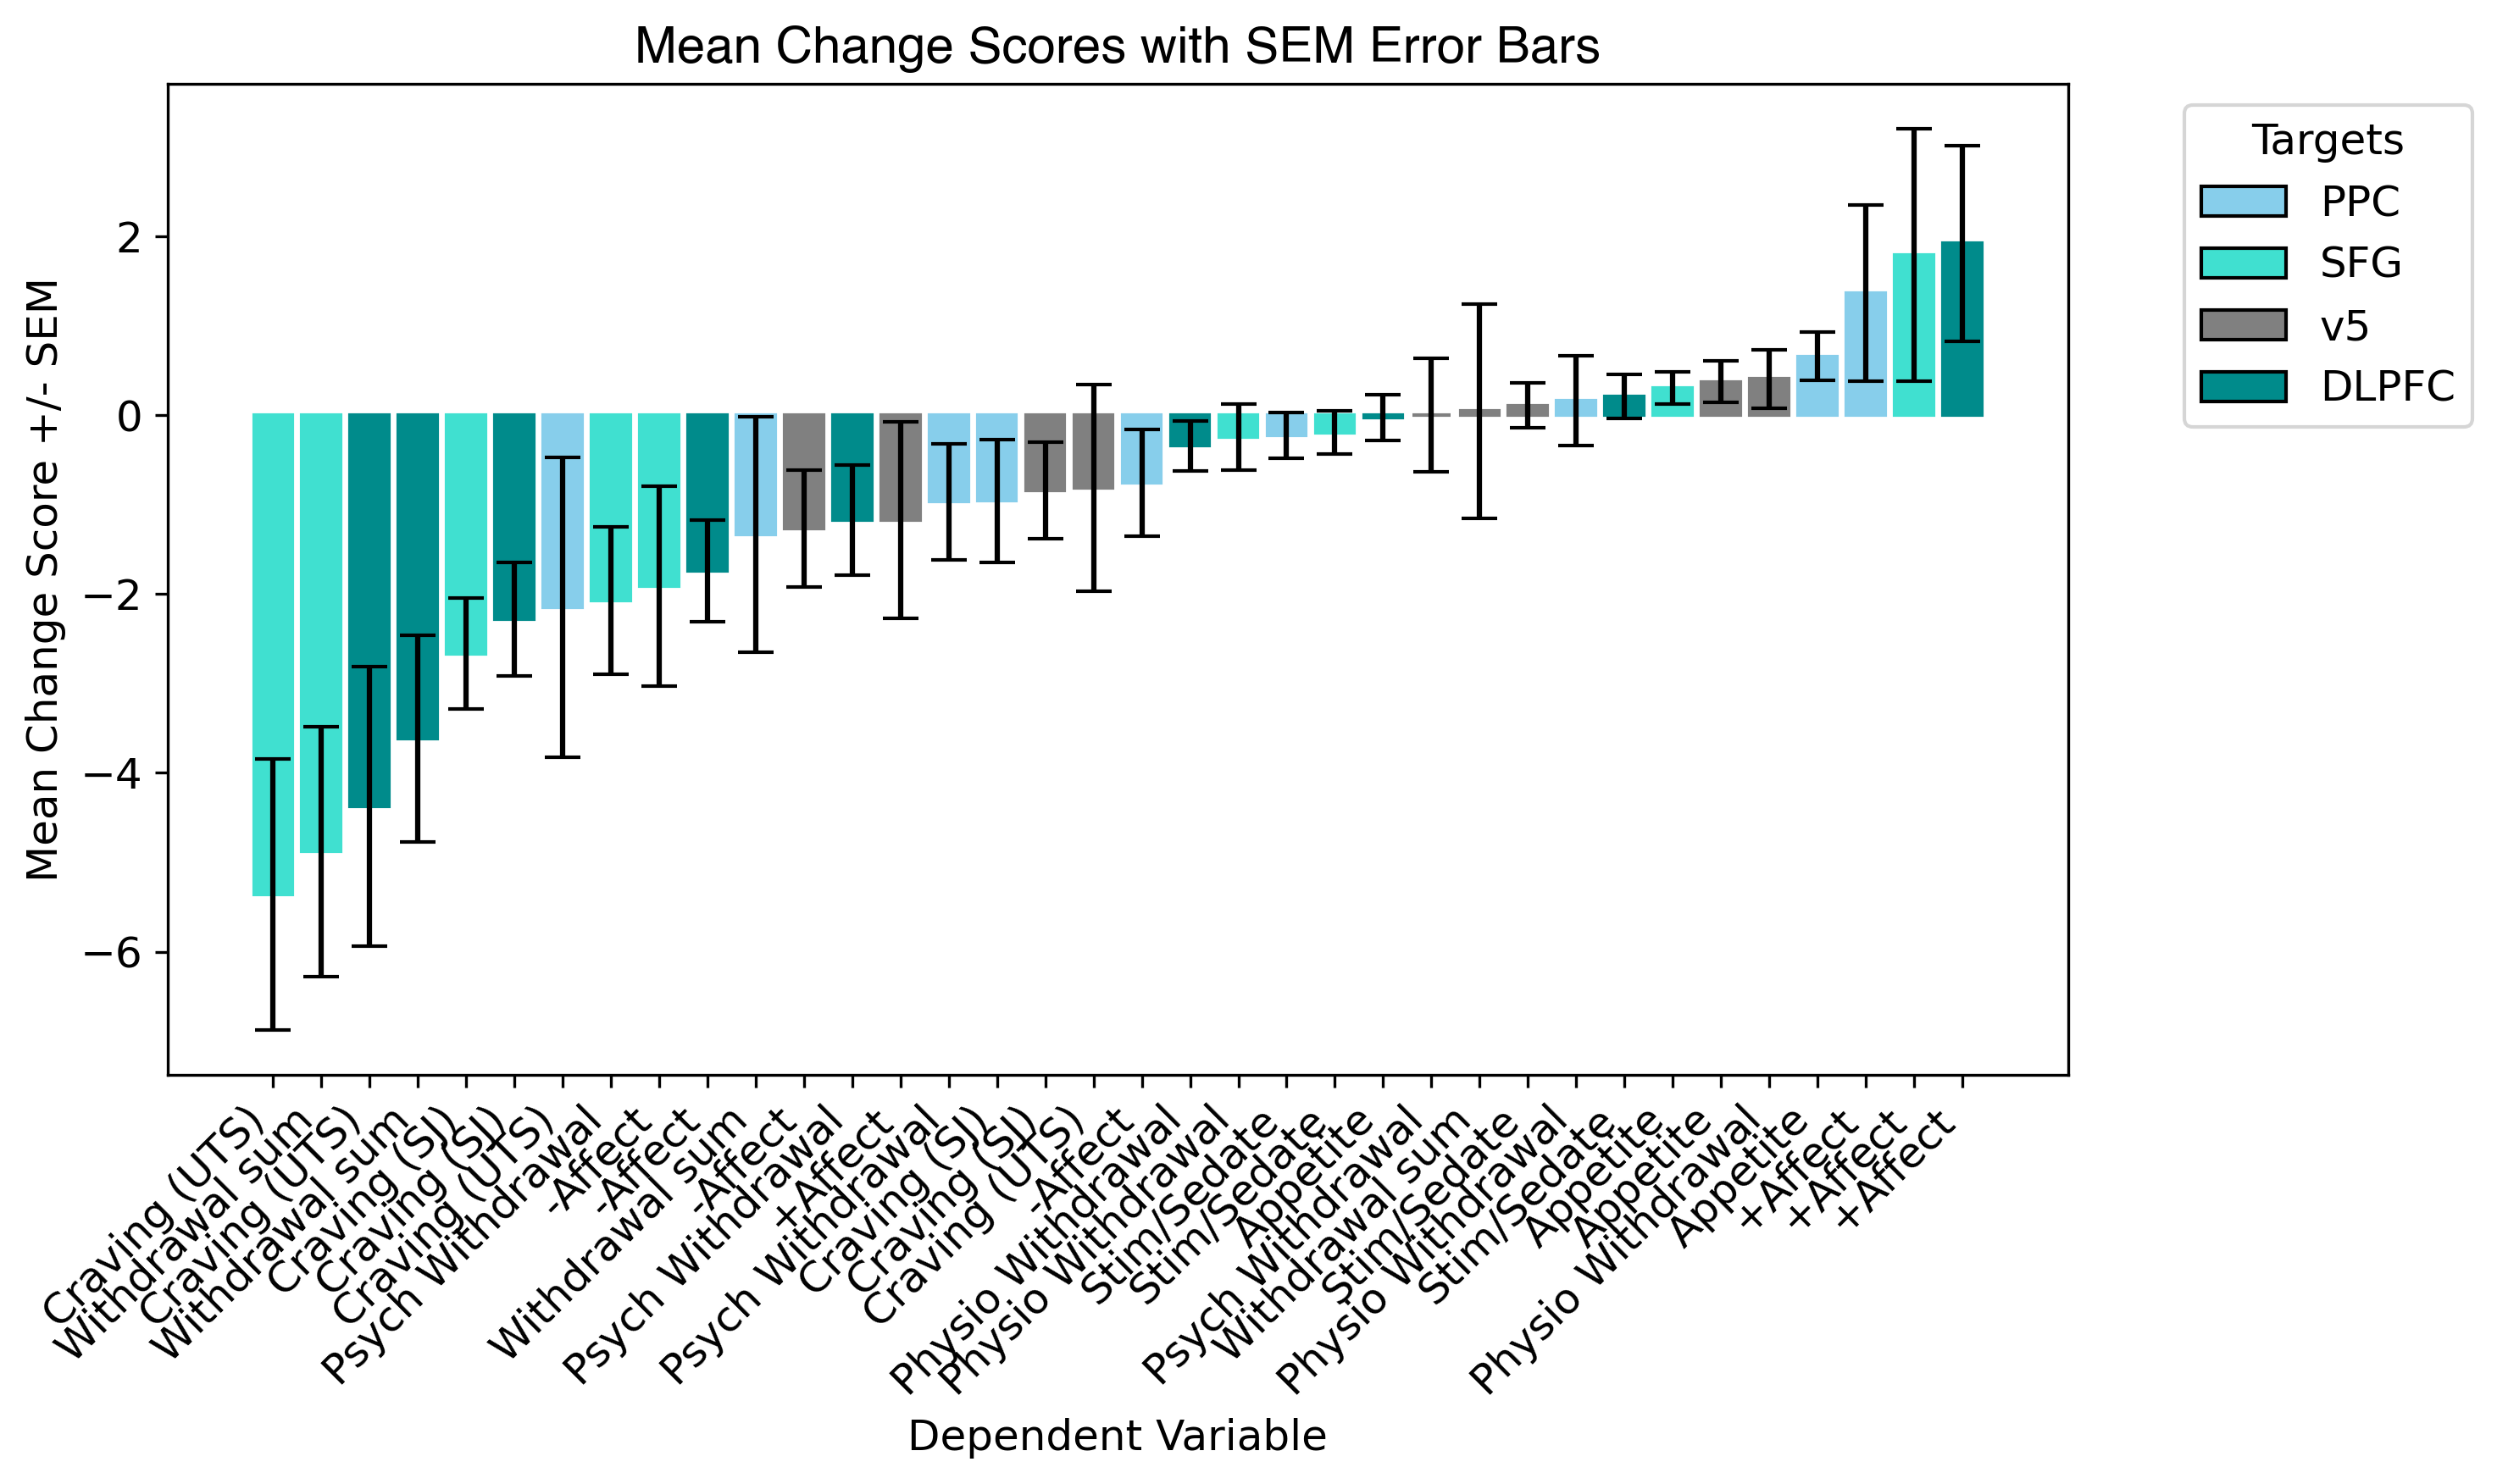

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Calculate the change scores (Post - Pre) for each subject, each target, and each dependent variable
change_scores = {}

for dependent_variable in dvs:
    for target in targets:
        # Filter data for the specific target
        subset_data = data[data['STITARGET'] == target]
        # Drop missing values for the relevant dependent variable
        subset_data = subset_data.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])

        if not subset_data.empty:
            pre_data = subset_data[subset_data['PrePost'] == 'Pre']
            post_data = subset_data[subset_data['PrePost'] == 'Post']
            
            # Calculate change scores for each subject
            change_score = post_data.groupby('PTID')[dependent_variable].mean() - pre_data.groupby('PTID')[dependent_variable].mean()
            
            # Store the change scores in the dictionary
            change_scores[f'{dependent_variable}_{target}'] = change_score

# Convert the change scores dictionary to a DataFrame
change_scores_df = pd.DataFrame.from_dict(change_scores, orient='index').transpose()

# calculate mean and SEM for each change score
mean_change_scores = change_scores_df.mean()
sem_change_scores = change_scores_df.sem()

# Print the mean and SEM for verification
print("Mean Change Scores:\n", mean_change_scores)
print("\nSEM of Change Scores:\n", sem_change_scores)

# mean +/- sem plot:
sorted_indices = mean_change_scores.sort_values().index
sorted_mean_change_scores = mean_change_scores[sorted_indices]
sorted_sem_change_scores = sem_change_scores[sorted_indices]

plt.figure(figsize=(10, 6), dpi=300)

# make it nice
colors = ['#87ceeb', '#40e0d0', 'gray', '#008b8b'] 
target_colors = {target: colors[i % len(colors)] for i, target in enumerate(targets)}
bar_colors = [target_colors[label.split('_')[-1]] for label in sorted_mean_change_scores.index]

# Create bar plot with individual colors
bars = plt.bar(sorted_mean_change_scores.index, sorted_mean_change_scores.values, yerr=sorted_sem_change_scores.values, capsize=5, edgecolor='black')

# Apply the colors to each bar
for bar, color in zip(bars, bar_colors):
    bar.set_color(color)
    
# Create legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=target) for target, color in target_colors.items()]
plt.legend(handles=legend_elements, title='Targets', bbox_to_anchor=(1.05, 1), loc='upper left')

# Simplify x-axis labels by removing the target names

# Assign simplified labels to the DataFrame
simplified_labels = [label.split('_')[0] + '_' + label.split('_')[1] for label in sorted_mean_change_scores.index]
plt.xticks(ticks=range(len(simplified_labels)), labels=simplified_labels, rotation=45, ha='right')

# Create a dictionary to make better labels for the plot
label_translation = {
    'SJW_SUM_C_PPC': 'Craving (SJ)',
    'SJW_SUM_C_SFG': 'Craving (SJ)',
    'SJW_SUM_C_v5': 'Craving (SJ)',
    'SJW_SUM_C_DLPFC': 'Craving (SJ)',
    'SJW_SUM_PSY_PPC': 'Psych Withdrawal',
    'SJW_SUM_PSY_SFG': 'Psych Withdrawal',
    'SJW_SUM_PSY_v5': 'Psych Withdrawal',
    'SJW_SUM_PSY_DLPFC': 'Psych Withdrawal',
    'SJW_SUM_PHY_PPC': 'Physio Withdrawal',
    'SJW_SUM_PHY_SFG': 'Physio Withdrawal',
    'SJW_SUM_PHY_v5': 'Physio Withdrawal',
    'SJW_SUM_PHY_DLPFC': 'Physio Withdrawal',
    'SJW_SUM_SS_PPC': 'Stim/Sedate',
    'SJW_SUM_SS_SFG': 'Stim/Sedate',
    'SJW_SUM_SS_v5': 'Stim/Sedate',
    'SJW_SUM_SS_DLPFC': 'Stim/Sedate',
    'SJW_SUM_A_PPC': 'Appetite',
    'SJW_SUM_A_SFG': 'Appetite',
    'SJW_SUM_A_v5': 'Appetite',
    'SJW_SUM_A_DLPFC': 'Appetite',
    'SJW_SUM_OVERALL_PPC': 'Withdrawal sum',
    'SJW_SUM_OVERALL_SFG': 'Withdrawal sum',
    'SJW_SUM_OVERALL_v5': 'Withdrawal sum',
    'SJW_SUM_OVERALL_DLPFC': 'Withdrawal sum',
    'PANAS_POS_TOT_PPC': '+Affect',
    'PANAS_POS_TOT_SFG': '+Affect',
    'PANAS_POS_TOT_v5': '+Affect',
    'PANAS_POS_TOT_DLPFC': '+Affect',
    'PANAS_NEG_TOT_PPC': '-Affect',
    'PANAS_NEG_TOT_SFG': '-Affect',
    'PANAS_NEG_TOT_v5': '-Affect',
    'PANAS_NEG_TOT_DLPFC': '-Affect',
    'UTS_TOT_PPC': 'Craving (UTS)',
    'UTS_TOT_SFG': 'Craving (UTS)',
    'UTS_TOT_v5': 'Craving (UTS)',
    'UTS_TOT_DLPFC': 'Craving (UTS)',
}

translated_labels = [label_translation.get(label, label) for label in sorted_indices]

# Adding labels and title
plt.xlabel('Dependent Variable')
plt.ylabel('Mean Change Score +/- SEM')
plt.title('Mean Change Scores with SEM Error Bars')
plt.xticks(ticks=range(len(translated_labels)), labels=translated_labels, rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.savefig('all_change_scores.png', dpi=300) 
plt.show()



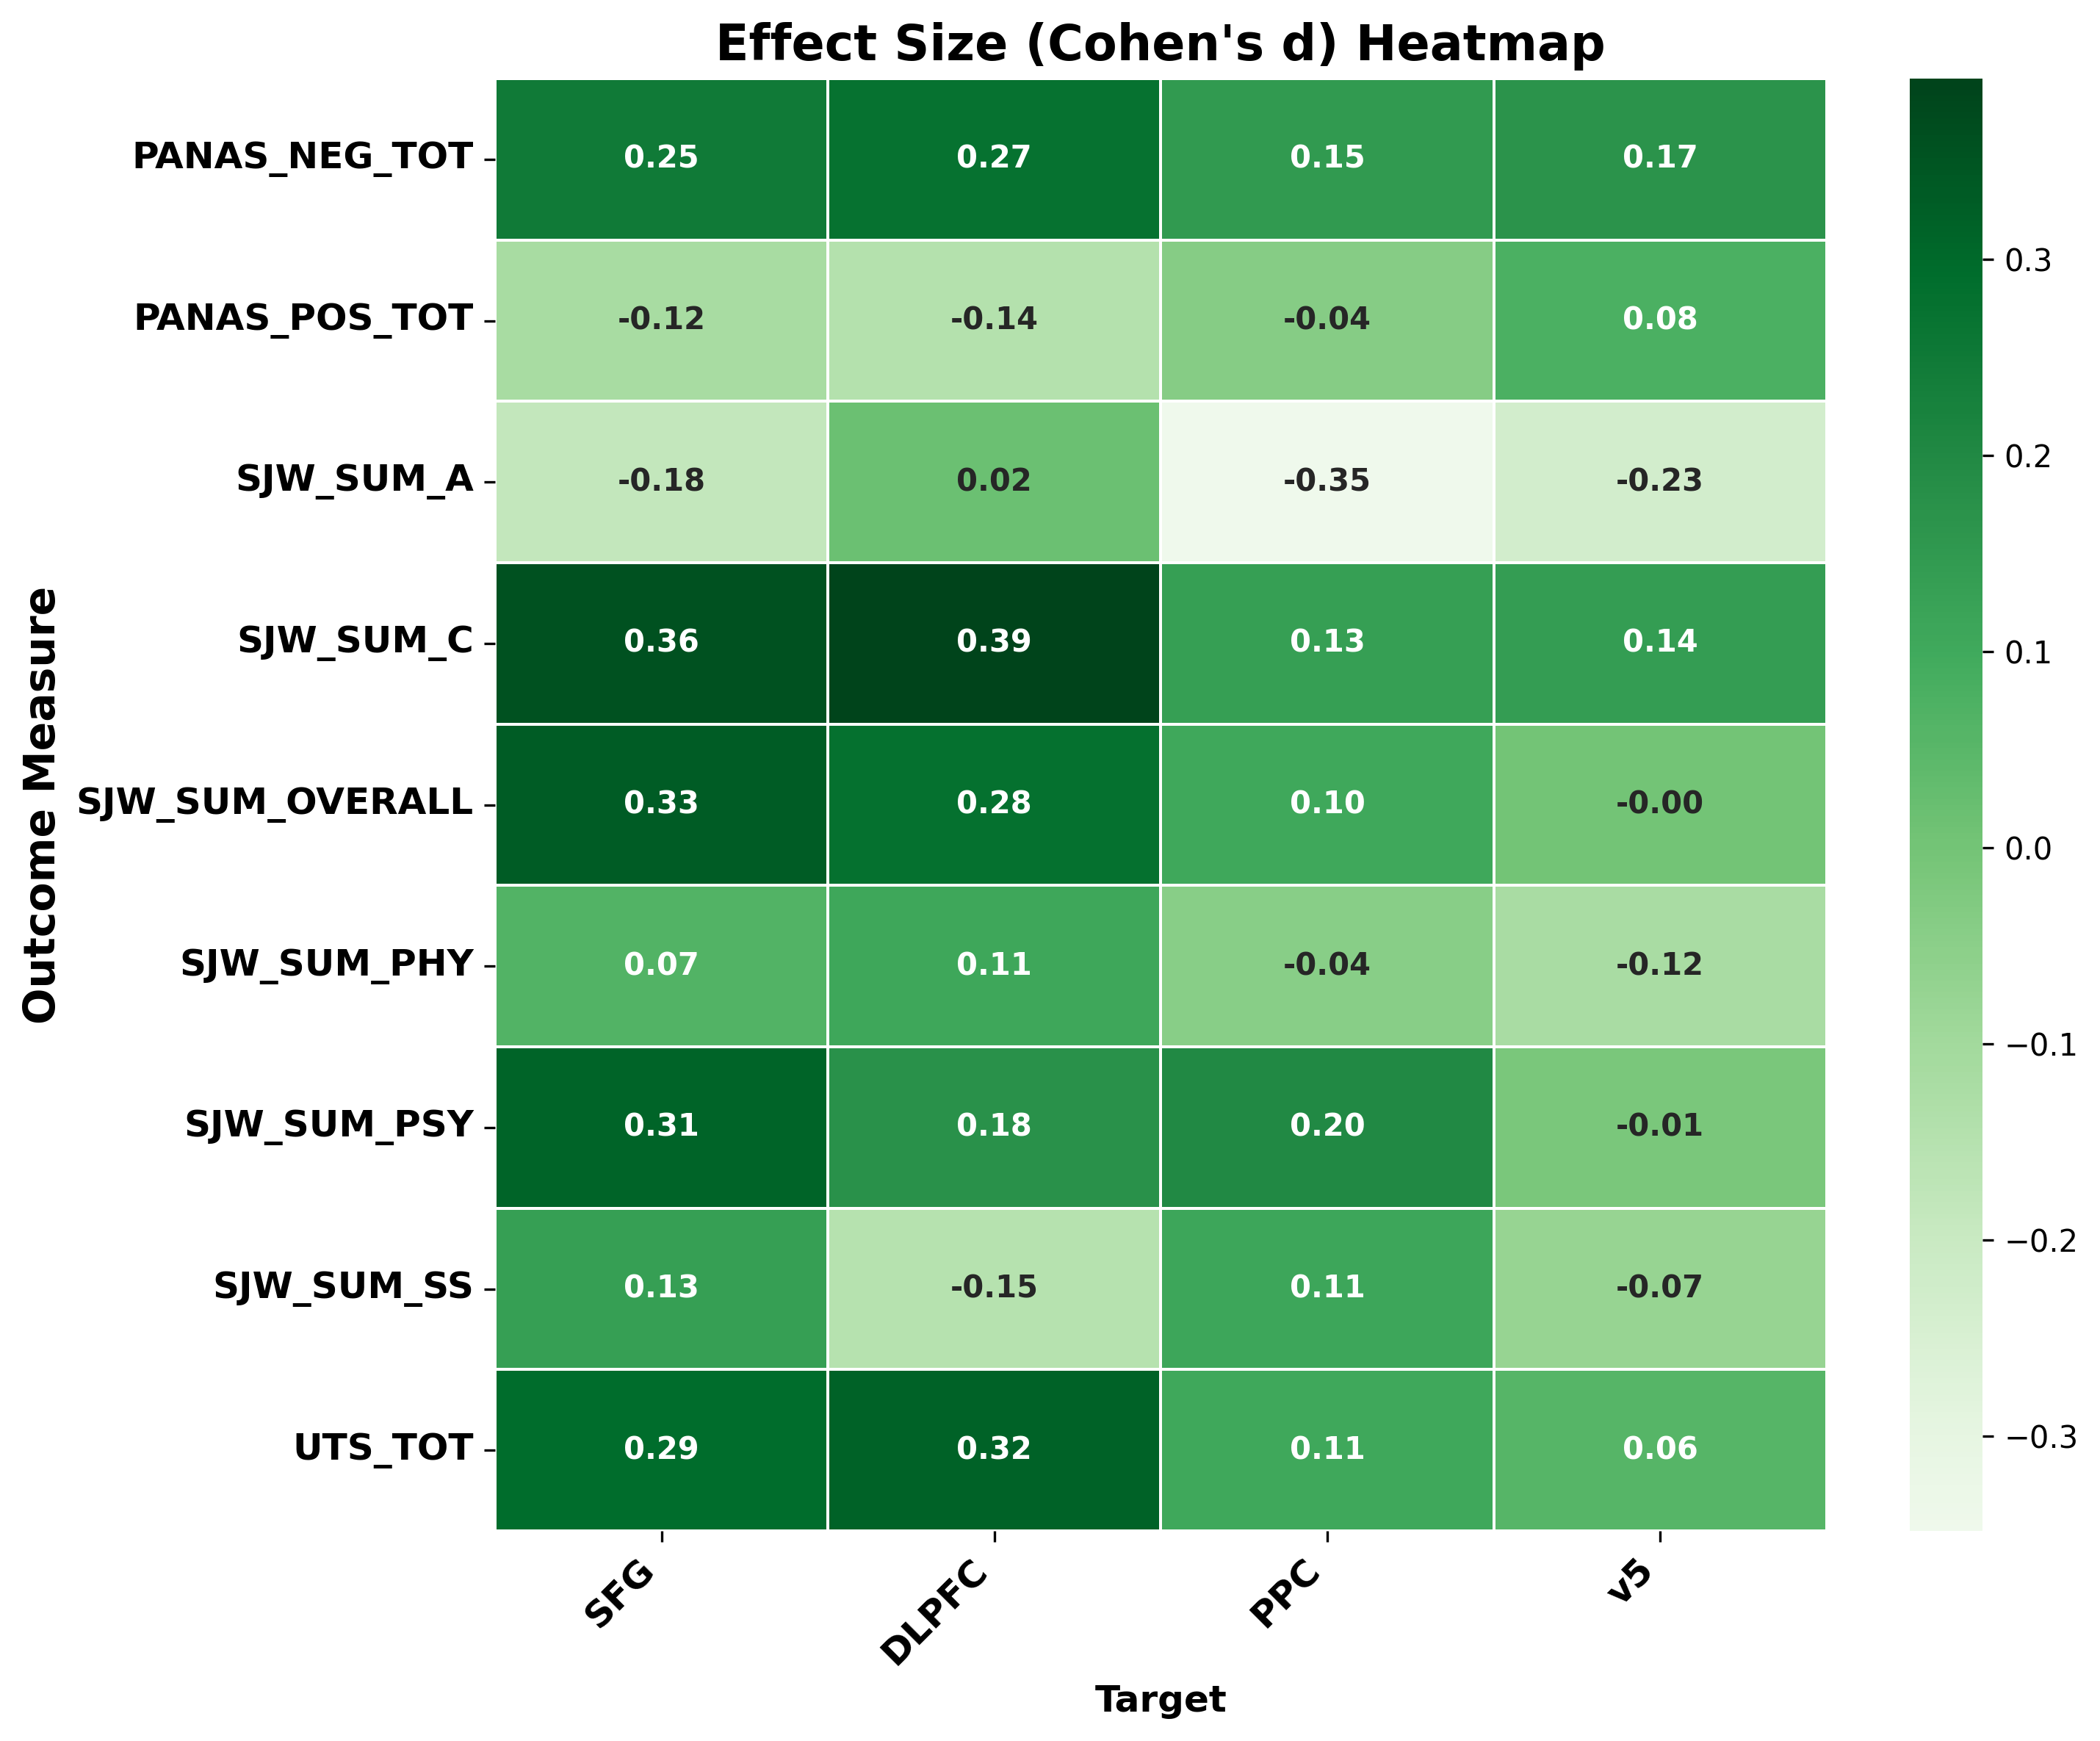

In [43]:


# Assuming the results_df is already created from the previous cell
# We need to reshape it into a matrix format suitable for heatmap visualization

# Extract the effect sizes (Cohen's d) for visualization and create a pivot table
effect_sizes_df = results_df[['effect_size (Cohen\'s d)']].reset_index()
effect_sizes_df[['Outcome', 'Target']] = effect_sizes_df['index'].str.rsplit('_', 1, expand=True)
effect_sizes_pivot = effect_sizes_df.pivot('Outcome', 'Target', 'effect_size (Cohen\'s d)')

# Reorder the columns
effect_sizes_pivot = effect_sizes_pivot[['SFG', 'DLPFC', 'PPC', 'v5']]

# Set up the plot with higher DPI and larger font sizes
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(effect_sizes_pivot, annot=True, cmap='Greens', center=0, linewidths=.5, 
            annot_kws={"size": 10, "weight": "bold"}, fmt=".2f")

# Customize the title and labels
plt.title('Effect Size (Cohen\'s d) Heatmap', fontsize=16, weight='bold')
plt.xlabel('Target', fontsize=12, weight='bold')
plt.ylabel('Outcome Measure', fontsize=12, weight='bold')

# Customize the tick labels
plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


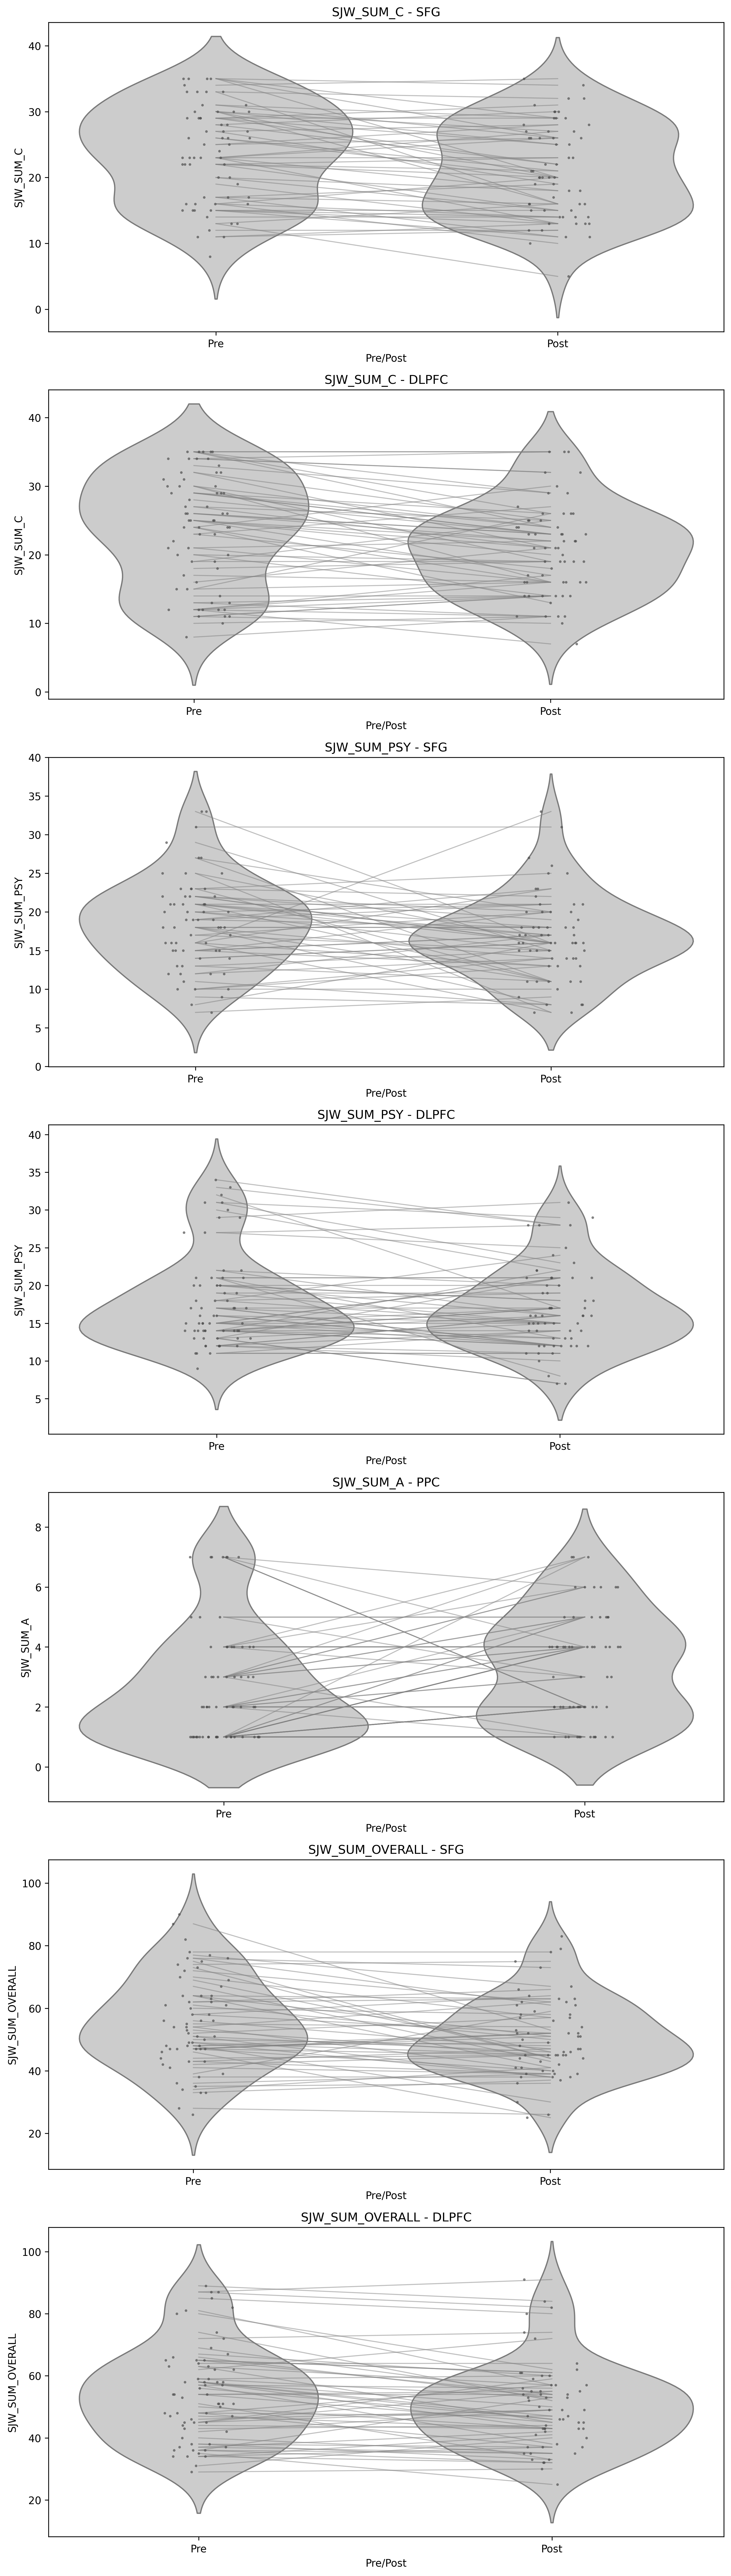

In [42]:
# Function to compute p-values and identify significant effects
def compute_p_values(data_clean, targets, sjw_subscales):
    results = {}
    for subscale in sjw_subscales:
        for target in targets:
            subset_data = data_clean[data_clean['STITARGET'] == target]
            if not subset_data.empty:
                model = smf.mixedlm(f"{subscale} ~ PrePost", subset_data, groups=subset_data["PTID"]).fit()
                if 'PrePost[T.Pre]' in model.pvalues:
                    results[f'{subscale}_{target}'] = model.pvalues['PrePost[T.Pre]']
    return results

# Compute p-values
p_values = compute_p_values(data_clean, targets, sjw_subscales)

# Filter significant effects (p-value < 0.05)
significant_effects = {k: v for k, v in p_values.items() if v < 0.05}

# Function to create raincloud plots for a given target and outcome measure
def create_raincloud_plot(data, target, outcome, ax):
    # Create the violin plot (raincloud)
    sns.violinplot(x='PrePost', y=outcome, data=data[data['STITARGET'] == target], ax=ax, inner=None, color=".8")

    # Add the aligned strip plot
    sns.stripplot(x='PrePost', y=outcome, data=data[data['STITARGET'] == target], ax=ax, size=2.5, color=".3", alpha=0.7)

    # Add connecting lines
    for ptid in data['PTID'].unique():
        ptid_data = data[(data['PTID'] == ptid) & (data['STITARGET'] == target)]
        if len(ptid_data) == 2:
            pre_data = ptid_data[ptid_data['PrePost'] == 'Pre'][outcome].values[0]
            post_data = ptid_data[ptid_data['PrePost'] == 'Post'][outcome].values[0]
            ax.plot([0, 1], [pre_data, post_data], color="gray", alpha=0.5, linewidth=1)

    ax.set_title(f'{outcome} - {target}')
    ax.set_xlabel('Pre/Post')
    ax.set_ylabel(outcome)

# Plotting significant effects
fig, axes = plt.subplots(len(significant_effects), 1, figsize=(10, len(significant_effects) * 5), dpi=300)
for i, (key, p_value) in enumerate(significant_effects.items()):
    outcome, target = key.rsplit('_', 1)
    create_raincloud_plot(data_clean, target, outcome, axes[i])

plt.tight_layout()
plt.show()

In [94]:
# attempting to clean up the for loops from above without breaking anything

# added this to try to get more precise p-values but it didn't work
pd.set_option('display.float_format', lambda x: f'{x:.4g}' if abs(x) < 1e-4 else f'{x:.4f}')

# Load the data
file_path = '/u/home/n/npeterse/TMS_data_copy.csv' 
data = pd.read_csv(file_path)

# Combine all necessary columns for dropna in one line -- but maybe this gets rid of too much data?

required_columns = ['PANAS_POS_TOT', 'SJW_SUM_OVERALL', 'STITARGET', 'PrePost', 'PTID', 'SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_A', 'SJW_SUM_OVERALL']
data_clean = data.dropna(subset=required_columns)

# list of all dependent variables
dvs = ['SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_A', 'SJW_SUM_OVERALL', 'PANAS_POS_TOT', 'PANAS_NEG_TOT', 'UTS_TOT']

# Function to compute Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

# Fit linear mixed models for each target separately for PANAS_POS_TOT and SJW subscales
targets = ['v5']

# put this back in a minute 
#targets = ['PPC', 'SFG', 'v5', 'DLPFC']

results = {}


# Models for each SJW subscale
for dependent_variable in dvs:
    for target in targets:
        subset_data = data_clean[data_clean['STITARGET'] == target]
        if not subset_data.empty:
            model = smf.mixedlm(f"{dependent_variable} ~ PrePost", subset_data, groups=subset_data["PTID"]).fit()
            if 'PrePost[T.Pre]' in model.pvalues:
                pre_data = subset_data[subset_data['PrePost'] == 'Pre'][dependent_variable]
                post_data = subset_data[subset_data['PrePost'] == 'Post'][dependent_variable]
                d = cohen_d(pre_data, post_data)
                results[f'{dependent_variable}_{target}'] = {
                    'p-value': model.pvalues['PrePost[T.Pre]'],
                    'effect_size (Cohen\'s d)': d
                }
                print(model.summary())
            else:
                results[f'{subscale}_{target}'] = {
                    'p-value': None,
                    'effect_size (Cohen\'s d)': None
                }

# Create DataFrame for p-values and effect sizes
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the DataFrame
print(results_df)

# Optionally, display the DataFrame in Jupyter Notebook for better visualization
results_df

# Fit the model
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: SJW_SUM_C
No. Observations:   130     Method:             REML     
No. Groups:         66      Scale:              9.3673   
Min. group size:    1       Log-Likelihood:     -405.3222
Max. group size:    2       Converged:          Yes      
Mean group size:    2.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      21.139    0.915 23.115 0.000 19.347 22.932
PrePost[T.Pre]  0.876    0.540  1.621 0.105 -0.183  1.935
Group Var      45.296    4.104                           

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SJW_SUM_PSY
No. Observations: 130     Method:             REML       
No. Groups:       66      Scale:              12.7723    
Min. group size:  1       Log-Lik

AttributeError: 'MixedLMResults' object has no attribute 'fit'

Mean Change Scores for Men:
 SJW_SUM_C_PPC           -1.2344
SJW_SUM_C_SFG           -3.0323
SJW_SUM_C_v5            -1.0541
SJW_SUM_C_DLPFC         -2.7742
SJW_SUM_PSY_PPC         -1.8750
SJW_SUM_PSY_SFG         -3.5968
SJW_SUM_PSY_v5          -1.2162
SJW_SUM_PSY_DLPFC       -1.2742
SJW_SUM_PHY_PPC         -0.3438
SJW_SUM_PHY_SFG         -0.3871
SJW_SUM_PHY_v5          -0.0811
SJW_SUM_PHY_DLPFC       -0.7903
SJW_SUM_SS_PPC                0
SJW_SUM_SS_SFG          -0.6613
SJW_SUM_SS_v5            0.0541
SJW_SUM_SS_DLPFC         0.3387
SJW_SUM_A_PPC            0.3438
SJW_SUM_A_SFG            0.3226
SJW_SUM_A_v5             0.0541
SJW_SUM_A_DLPFC         -0.1774
SJW_SUM_OVERALL_PPC     -3.1094
SJW_SUM_OVERALL_SFG     -7.3548
SJW_SUM_OVERALL_v5      -2.2432
SJW_SUM_OVERALL_DLPFC   -4.6774
PANAS_POS_TOT_PPC        0.7188
PANAS_POS_TOT_v5         0.3243
PANAS_POS_TOT_DLPFC      2.1452
PANAS_NEG_TOT_PPC       -0.9531
PANAS_NEG_TOT_v5        -1.6216
PANAS_NEG_TOT_DLPFC     -1.8710
UTS_TOT_PPC

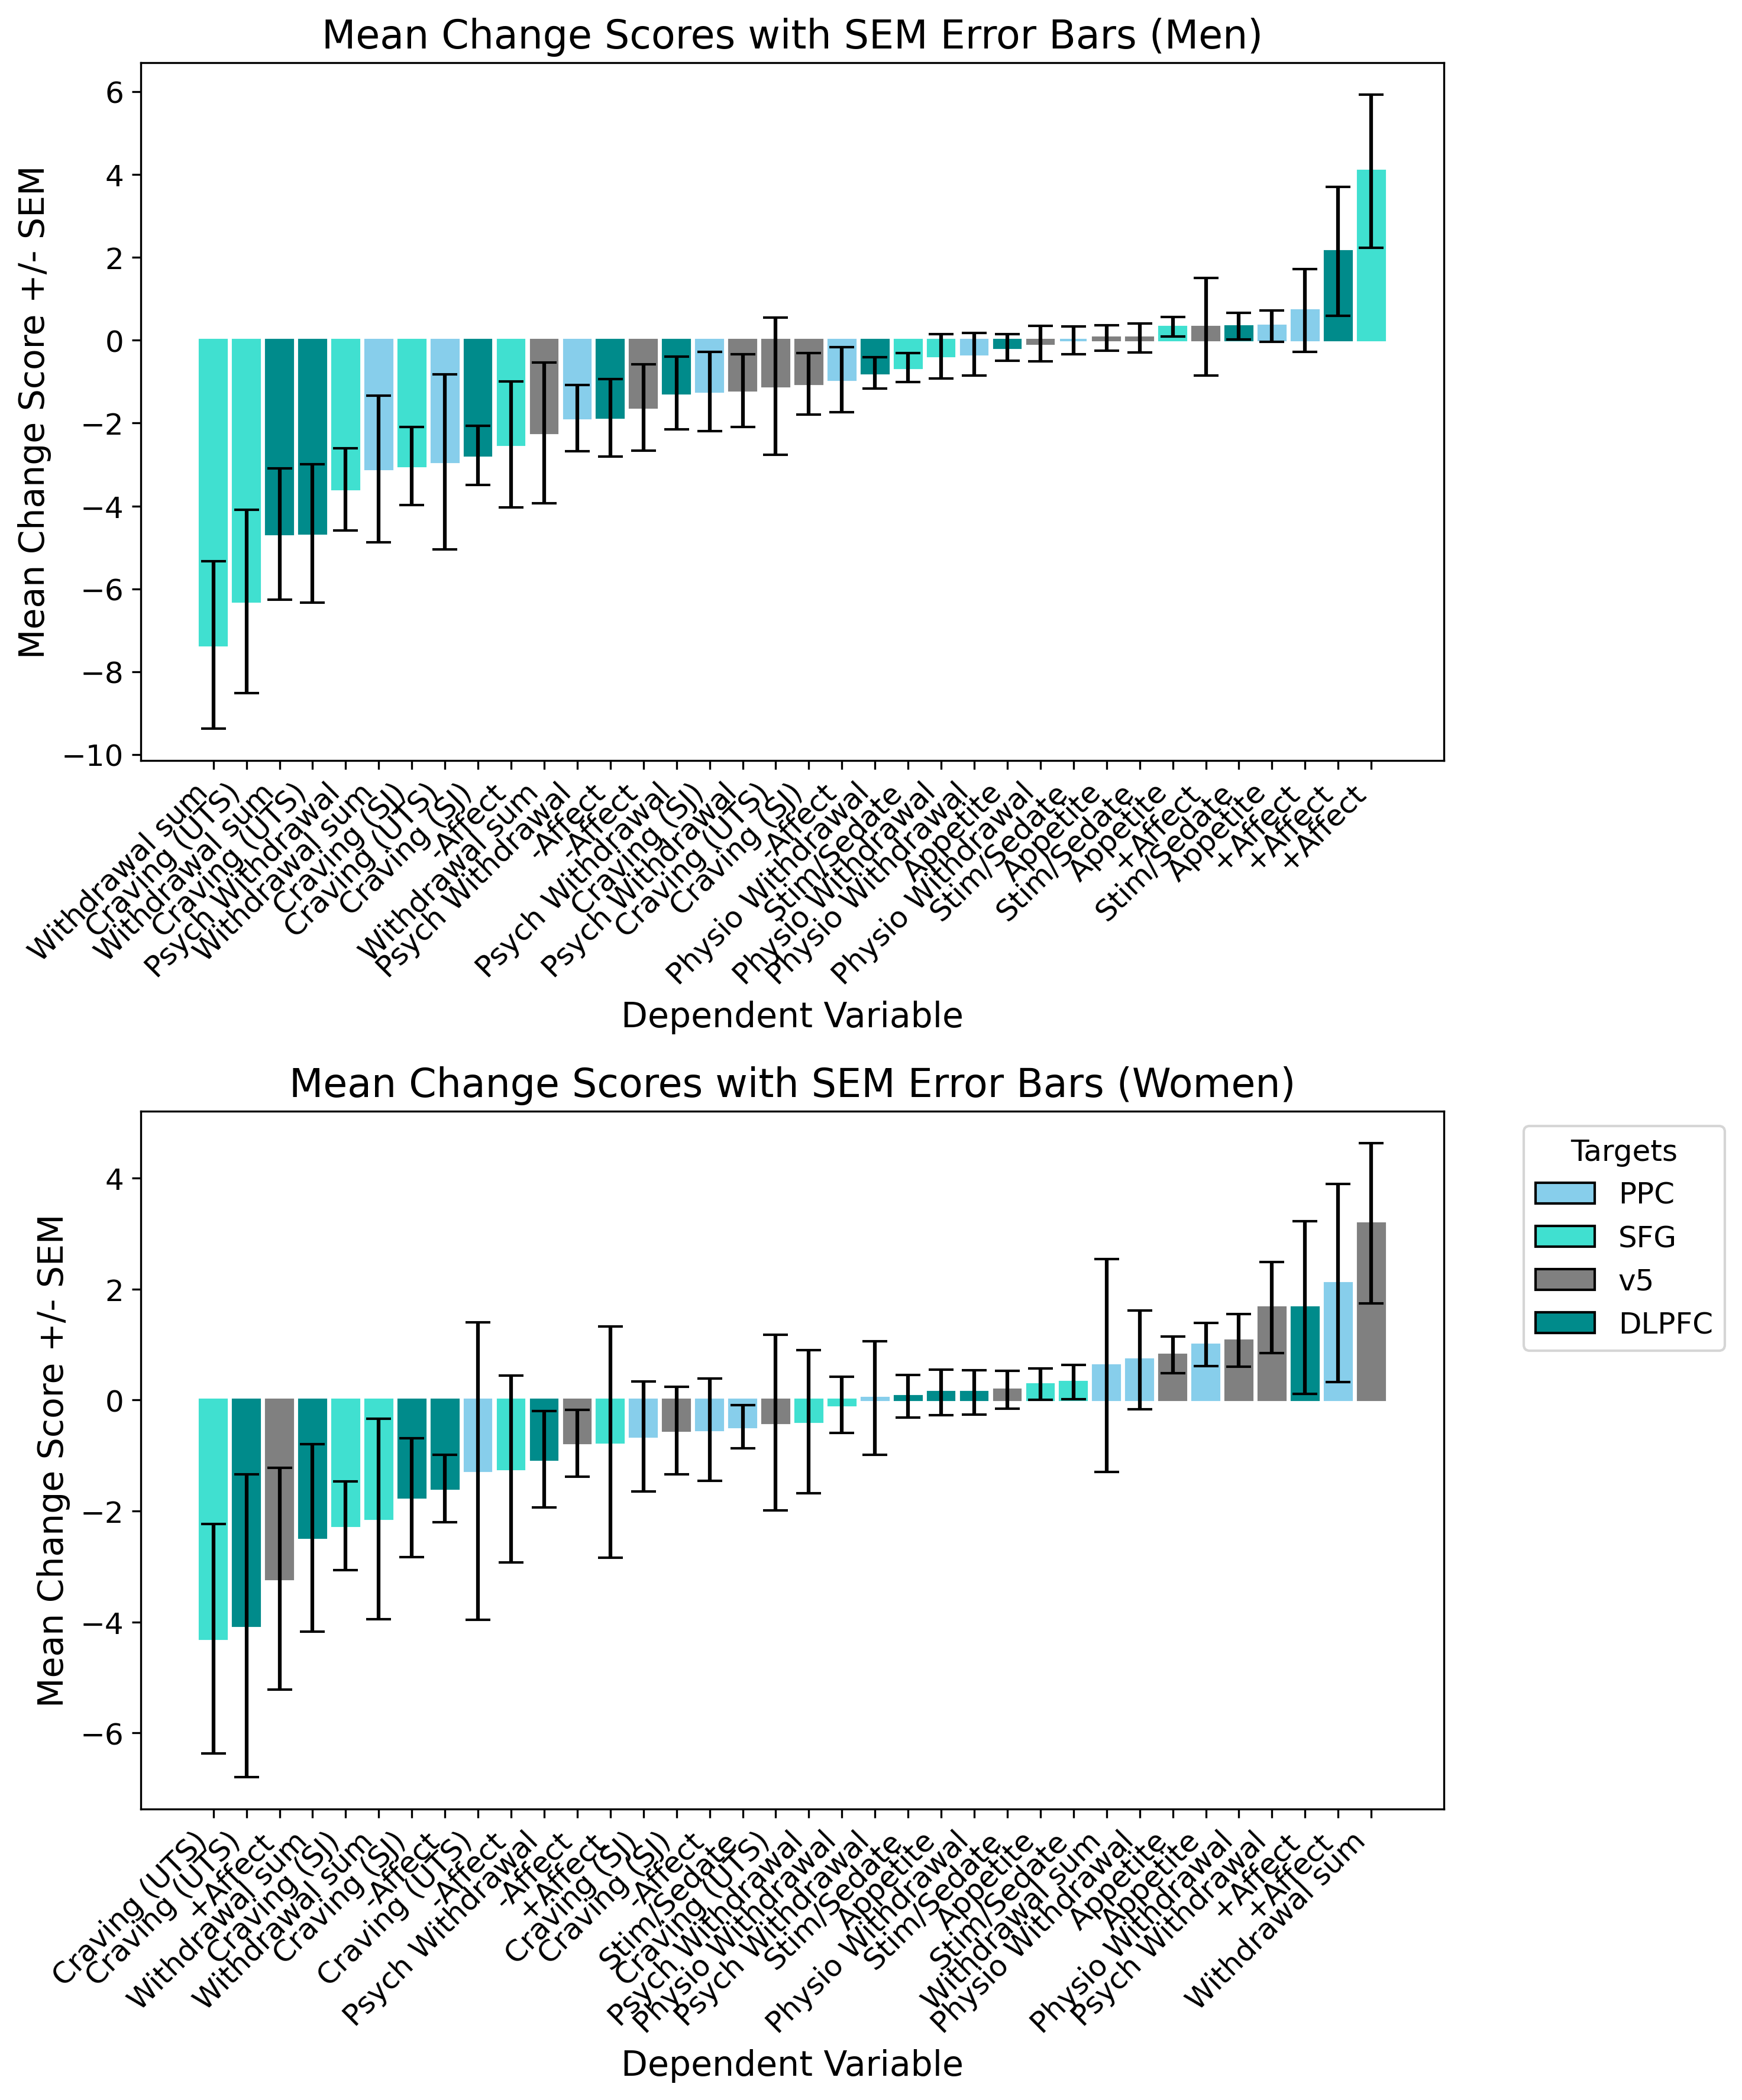

In [79]:
# Calculate the change scores (Post - Pre) for each subject, each target, each dependent variable, and each sex
change_scores_men = {}
change_scores_women = {}

for dependent_variable in dvs:
    for target in targets:
        # Filter data for the specific target and sex
        subset_data_men = data[(data['STITARGET'] == target) & (data['Sex'] == 'Male')]
        subset_data_women = data[(data['STITARGET'] == target) & (data['Sex'] == 'Female')]
        
        # Drop missing values for the relevant dependent variable
        subset_data_men = subset_data_men.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])
        subset_data_women = subset_data_women.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])

        if not subset_data_men.empty:
            pre_data_men = subset_data_men[subset_data_men['PrePost'] == 'Pre']
            post_data_men = subset_data_men[subset_data_men['PrePost'] == 'Post']
            change_score_men = post_data_men.groupby('PTID')[dependent_variable].mean() - pre_data_men.groupby('PTID')[dependent_variable].mean()
            change_scores_men[f'{dependent_variable}_{target}'] = change_score_men
        
        if not subset_data_women.empty:
            pre_data_women = subset_data_women[subset_data_women['PrePost'] == 'Pre']
            post_data_women = subset_data_women[subset_data_women['PrePost'] == 'Post']
            change_score_women = post_data_women.groupby('PTID')[dependent_variable].mean() - pre_data_women.groupby('PTID')[dependent_variable].mean()
            change_scores_women[f'{dependent_variable}_{target}'] = change_score_women

# Convert the change scores dictionary to DataFrames
change_scores_men_df = pd.DataFrame.from_dict(change_scores_men, orient='index').transpose()
change_scores_women_df = pd.DataFrame.from_dict(change_scores_women, orient='index').transpose()

# Calculate mean and SEM for each change score
mean_change_scores_men = change_scores_men_df.mean()
sem_change_scores_men = change_scores_men_df.sem()
mean_change_scores_women = change_scores_women_df.mean()
sem_change_scores_women = change_scores_women_df.sem()

# Print the mean and SEM for verification
print("Mean Change Scores for Men:\n", mean_change_scores_men)
print("\nSEM of Change Scores for Men:\n", sem_change_scores_men)
print("Mean Change Scores for Women:\n", mean_change_scores_women)
print("\nSEM of Change Scores for Women:\n", sem_change_scores_women)

# Define colors for the targets
colors = ['#87ceeb', '#40e0d0', 'gray', '#008b8b']
target_colors = {target: colors[i % len(colors)] for i, target in enumerate(targets)}

# Sort the indices for plotting
sorted_indices_men = mean_change_scores_men.sort_values().index
sorted_indices_women = mean_change_scores_women.sort_values().index

# Create a dictionary for label translation
label_translation = {
    'SJW_SUM_C_PPC': 'Craving (SJ)',
    'SJW_SUM_C_SFG': 'Craving (SJ)',
    'SJW_SUM_C_v5': 'Craving (SJ)',
    'SJW_SUM_C_DLPFC': 'Craving (SJ)',
    'SJW_SUM_PSY_PPC': 'Psych Withdrawal',
    'SJW_SUM_PSY_SFG': 'Psych Withdrawal',
    'SJW_SUM_PSY_v5': 'Psych Withdrawal',
    'SJW_SUM_PSY_DLPFC': 'Psych Withdrawal',
    'SJW_SUM_PHY_PPC': 'Physio Withdrawal',
    'SJW_SUM_PHY_SFG': 'Physio Withdrawal',
    'SJW_SUM_PHY_v5': 'Physio Withdrawal',
    'SJW_SUM_PHY_DLPFC': 'Physio Withdrawal',
    'SJW_SUM_SS_PPC': 'Stim/Sedate',
    'SJW_SUM_SS_SFG': 'Stim/Sedate',
    'SJW_SUM_SS_v5': 'Stim/Sedate',
    'SJW_SUM_SS_DLPFC': 'Stim/Sedate',
    'SJW_SUM_A_PPC': 'Appetite',
    'SJW_SUM_A_SFG': 'Appetite',
    'SJW_SUM_A_v5': 'Appetite',
    'SJW_SUM_A_DLPFC': 'Appetite',
    'SJW_SUM_OVERALL_PPC': 'Withdrawal sum',
    'SJW_SUM_OVERALL_SFG': 'Withdrawal sum',
    'SJW_SUM_OVERALL_v5': 'Withdrawal sum',
    'SJW_SUM_OVERALL_DLPFC': 'Withdrawal sum',
    'PANAS_POS_TOT_PPC': '+Affect',
    'PANAS_POS_TOT_SFG': '+Affect',
    'PANAS_POS_TOT_v5': '+Affect',
    'PANAS_POS_TOT_DLPFC': '+Affect',
    'PANAS_NEG_TOT_PPC': '-Affect',
    'PANAS_NEG_TOT_SFG': '-Affect',
    'PANAS_NEG_TOT_v5': '-Affect',
    'PANAS_NEG_TOT_DLPFC': '-Affect',
    'UTS_TOT_PPC': 'Craving (UTS)',
    'UTS_TOT_SFG': 'Craving (UTS)',
    'UTS_TOT_v5': 'Craving (UTS)',
    'UTS_TOT_DLPFC': 'Craving (UTS)',
}

# Translate the labels using the dictionary
translated_labels_men = [label_translation.get(label, label) for label in sorted_indices_men]
translated_labels_women = [label_translation.get(label, label) for label in sorted_indices_women]

# Set the font properties
font_manager.fontManager.addfont(font_path)
plt.rcParams.update({'font.family': 'helvetica', 'font.size': 12, 'font.weight': 'normal'})

# Plot mean +/- sem for men and women
plt.figure(figsize=(10, 12), dpi=300)  # Increase DPI for higher resolution

# Create bar plots with error bars for men
plt.subplot(2, 1, 1)
bars_men = plt.bar(sorted_indices_men, mean_change_scores_men[sorted_indices_men].values, yerr=sem_change_scores_men[sorted_indices_men].values, capsize=5, edgecolor='black')
bar_colors_men = [target_colors[label.split('_')[-1]] for label in sorted_indices_men]

# Apply the colors to each bar
for bar, color in zip(bars_men, bar_colors_men):
    bar.set_color(color)

plt.xticks(ticks=range(len(translated_labels_men)), labels=translated_labels_men, rotation=45, ha='right')
plt.xlabel('Dependent Variable', fontsize=14)
plt.ylabel('Mean Change Score +/- SEM', fontsize=14)
plt.title('Mean Change Scores with SEM Error Bars (Men)', fontsize=16)

# Create bar plots with error bars for women
plt.subplot(2, 1, 2)
bars_women = plt.bar(sorted_indices_women, mean_change_scores_women[sorted_indices_women].values, yerr=sem_change_scores_women[sorted_indices_women].values, capsize=5, edgecolor='black')
bar_colors_women = [target_colors[label.split('_')[-1]] for label in sorted_indices_women]

# Apply the colors to each bar
for bar, color in zip(bars_women, bar_colors_women):
    bar.set_color(color)

plt.xticks(ticks=range(len(translated_labels_women)), labels=translated_labels_women, rotation=45, ha='right')
plt.xlabel('Dependent Variable', fontsize=14)
plt.ylabel('Mean Change Score +/- SEM', fontsize=14)
plt.title('Mean Change Scores with SEM Error Bars (Women)', fontsize=16)

# Create legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=target) for target, color in target_colors.items()]
plt.legend(handles=legend_elements, title='Targets', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('sex_diff_change_scores.png', dpi=300)
plt.show()
